In [ ]:
import pyart
import xarray as xr
from s3fs import S3FileSystem
import numpy as np
import datetime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.pyplot import cm as cmaps
import pandas as pd

In [1]:
%matplotlib inline

In [ ]:
# read in radar data
radar = pyart.io.read_nexrad_archive("s3://noaa-nexrad-level2/2021/05/26/KGLD/KGLD20210526_155623_V06")


In [ ]:
# read in satellite data
fs = s3fs.S3FileSystem(anon=True)
aws_url = 's3://noaa-goes16/ABI-L2-MCMIPC/2021/146/15/OR_ABI-L2-MCMIPC-M6_G16_s20211461556154_e20211461558539_c20211461559030.nc'

goes_data = xr.open_dataset(fs.open(aws_url), engine='h5netcdf')


In [ ]:
'''
Because the GOES data comes in without latitude/longitude values, we need to calculate those. 
'''

def lat_lon_reproj(g16nc):

    # GOES-R projection info and retrieving relevant constants
    proj_info = g16nc["goes_imager_projection"]
    lon_origin = proj_info.attrs["longitude_of_projection_origin"]
    H = proj_info.attrs["perspective_point_height"] + proj_info.attrs["semi_major_axis"]
    r_eq = proj_info.attrs["semi_major_axis"]
    r_pol = proj_info.attrs["semi_minor_axis"]

    # grid info
    lat_rad_1d = g16nc.variables["x"][:]
    lon_rad_1d = g16nc.variables["y"][:]

    # create meshgrid filled with radian angles
    lat_rad, lon_rad = np.meshgrid(lat_rad_1d, lon_rad_1d)

    # lat/lon calc routine from satellite radian angle vectors

    lambda_0 = (lon_origin * np.pi) / 180.0

    a_var = np.power(np.sin(lat_rad), 2.0) + (
        np.power(np.cos(lat_rad), 2.0)
        * (
            np.power(np.cos(lon_rad), 2.0)
            + (((r_eq * r_eq) / (r_pol * r_pol)) * np.power(np.sin(lon_rad), 2.0))
        )
    )
    b_var = -2.0 * H * np.cos(lat_rad) * np.cos(lon_rad)
    c_var = (H**2.0) - (r_eq**2.0)

    r_s = (-1.0 * b_var - np.sqrt((b_var**2) - (4.0 * a_var * c_var))) / (2.0 * a_var)

    s_x = r_s * np.cos(lat_rad) * np.cos(lon_rad)
    s_y = -r_s * np.sin(lat_rad)
    s_z = r_s * np.cos(lat_rad) * np.sin(lon_rad)

    lat = (180.0 / np.pi) * (
        np.arctan(
            ((r_eq * r_eq) / (r_pol * r_pol))
            * ((s_z / np.sqrt(((H - s_x) * (H - s_x)) + (s_y * s_y))))
        )
    )
    lon = (lambda_0 - np.arctan(s_y / (H - s_x))) * (180.0 / np.pi)

    return lon, lat


In [ ]:
# First, we need to grid the input radar data. 
grid = pyart.map.grid_from_radars(radar, grid_shape=(41, 401, 401),
                                  grid_limits=((0.,20000,), (-200000., 200000.), (-200000, 200000.)))


In [ ]:
# In Py-ART's graphing suite, there is a display class similar to RadarMapDisplay,
# but for grids. To plot the grid:
fig = plt.figure(figsize=[8, 8])
plt.axis('off')

display = pyart.graph.GridMapDisplay(grid)
display.plot_grid('reflectivity', level=3, vmin=0, vmax=60, fig=fig)


In [ ]:
xr_grid = grid.to_xarray()

In [ ]:
goes_data['time_bounds'][0].values

In [ ]:
goes_data['time_bounds'][0].values

In [ ]:
llons, llats  = lat_lon_reproj(goes_data)
full_goes_data = goes_data['CMI_C10'].values
in_goes_for_tobac = xr.Dataset(data_vars=
    {
        "C10": (("time","Y", "X"), [full_goes_data],)
    },
    coords=
    {
        "time": [goes_data['time_bounds'][0].values],
    "longitude": (["Y", "X"], llons),
    "latitude": (["Y", "X"], llats)},
)


In [ ]:
import tobac
import tobac.utils

In [ ]:
feature_detection_params = dict()
feature_detection_params['threshold'] = [30, 40, 50]
feature_detection_params['target'] = 'maximum'
feature_detection_params['position_threshold'] = 'weighted_diff'
feature_detection_params['n_erosion_threshold'] = 2
feature_detection_params['sigma_threshold'] = 1
feature_detection_params['n_min_threshold'] = 4


In [ ]:
xr_grid_full = xr_grid['reflectivity'][:,4]
xr_grid_full['z'] = xr_grid_full.z.assign_attrs({'standard_name': 'altitude'})
xr_grid_full['lat'] = xr_grid_full.lat.assign_attrs({'standard_name': 'latitude'})
xr_grid_full['lon'] = xr_grid_full.lon.assign_attrs({'standard_name': 'longitude'})


In [ ]:
grid_iris = xr_grid_full.to_iris()


In [ ]:
out_fd = tobac.feature_detection.feature_detection_multithreshold(grid_iris, 0, **feature_detection_params)

In [ ]:
out_fd

In [ ]:
# we now have 4 detected features in 3D space. 

fig = plt.figure(figsize=[10, 8])
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-101.7, -100.7, 39, 40], crs=ccrs.PlateCarree())

cm = ax.pcolormesh(xr_grid['lon'], xr_grid['lat'], xr_grid['reflectivity'][0,4], vmin=-30, vmax=95, 
                  transform=ccrs.PlateCarree(), cmap = 'viridis')
plt.xlim(-101.7, -100.7)
plt.ylim(39., 40)
cb = plt.colorbar(cm)
cb.set_label("Reflectivity (dBZ)", size=14)
cb.ax.tick_params(labelsize=14)
plt.title("KGLD Reflectivity, 2 km AGL, 2021-05-26 15:56", size=15)
plt.scatter(out_fd['longitude'], out_fd['latitude'], 70, transform=ccrs.PlateCarree(), color='grey')


In [ ]:
goes_array_iris = in_goes_for_tobac["C10"].to_iris()

In [ ]:
in_goes_for_tobac

In [3]:
goes_adj_features = tobac.utils.transform_feature_points(out_fd, goes_array_iris)

NameError: name 'tobac' is not defined

In [23]:
# the transformed dataframe needs to have identical time to the data to segment on. 
replacement_dt = np.datetime64(in_goes_for_tobac['time'][0].values, 's')
# however, iris cannot deal with times in ms, so we need to drop the ms values.

goes_adj_features['time'] = replacement_dt

In [24]:
field_time = goes_array_iris.slices_over("time")

In [25]:
goes_adj_features

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,projection_y_coordinate,projection_x_coordinate,altitude,latitude,longitude
index,,,,,,,,,,,,,,
0,0.0,5.0,373.0,804.0,19.0,30.0,1.0,2021-05-26 15:56:15,2021-05-26 15:56:23,58862.283394,71851.508790,71851.508790,39.872883,-100.885201
1,0.0,9.0,377.0,790.0,6.0,40.0,2.0,2021-05-26 15:56:15,2021-05-26 15:56:23,50469.609023,40740.283111,40740.283111,39.797444,-101.238116
2,0.0,11.0,394.0,777.0,54.0,50.0,3.0,2021-05-26 15:56:15,2021-05-26 15:56:23,-1221.241920,25305.251870,25305.251870,39.332809,-101.413212
3,0.0,12.0,380.0,780.0,7.0,50.0,4.0,2021-05-26 15:56:15,2021-05-26 15:56:23,43316.368018,17254.571781,17254.571781,39.733146,-101.504540


In [26]:
parameters_segmentation=dict()
parameters_segmentation['method']='watershed'
parameters_segmentation['threshold']=235
parameters_segmentation['target']='minimum'


In [27]:
seg_data, seg_feats = tobac.segmentation.segmentation(goes_adj_features, goes_array_iris, dxy=2000,**parameters_segmentation)

In [28]:
seg_data_xr = xr.DataArray.from_iris(seg_data)

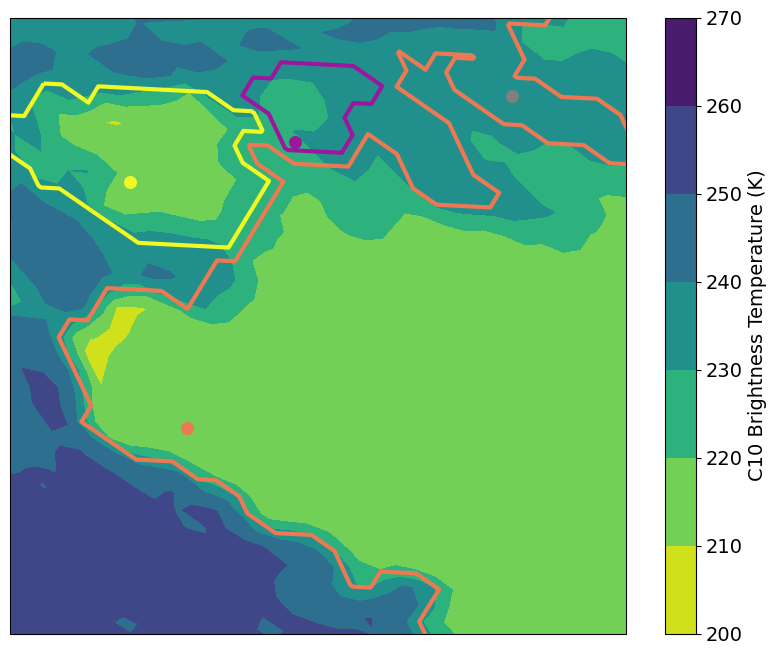

In [29]:
# In Py-ART's graphing suite, there is a display class similar to RadarMapDisplay,
# but for grids. To plot the grid:
fig = plt.figure(figsize=[10, 8])
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-101.7, -100.7, 39, 40], crs=ccrs.PlateCarree())

contoured = ax.contourf(in_goes_for_tobac['longitude'], in_goes_for_tobac['latitude'], in_goes_for_tobac['C10'][0],
                  transform=ccrs.PlateCarree(), cmap = 'viridis_r')
plt.xlim(-101.7, -100.7)
plt.ylim(39., 40)
unique_seg = np.unique(seg_data_xr)
color_map = cmaps.plasma(np.linspace(0, 1, len(unique_seg)))

# we have one feature without a segmented area
curr_feat = goes_adj_features[goes_adj_features['feature']==1]
plt.scatter(curr_feat['longitude'], curr_feat['latitude'], 70, transform=ccrs.PlateCarree(), color='grey')


for seg_num, color in zip(unique_seg, color_map):
    if seg_num == 0:
        continue
    curr_seg = (seg_data_xr == seg_num).astype(int)
    ax.contour(seg_data_xr['longitude'], seg_data_xr['latitude'], curr_seg, colors=[color,], levels=[0.9,], linewidths=3)
    curr_feat = goes_adj_features[goes_adj_features['feature']==seg_num]
    plt.scatter(curr_feat['longitude'], curr_feat['latitude'], 70, transform=ccrs.PlateCarree(), color=color)

cb = plt.colorbar(contoured)
cb.set_label("C10 Brightness Temperature (K)", size=14)
cb.ax.tick_params(labelsize=14)
#plt.title("KGLD Reflectivity, 2 km AGL, 2021-05-26 15:56", size=15)
#plt.savefig("./radar_example_2/satellite_wseg.png", facecolor='w', bbox_inches='tight')